# 中国癌症患者数据集生存分析：数据预处理

本notebook专注于中国癌症患者数据集的数据预处理，为后续的Cox回归、Random Survival Forest与DeepSurv深度学习模型对比研究做准备。

## 研究目标
- 对癌症患者数据进行全面的数据清洗和特征工程
- 准备统一的数据格式供三种生存分析模型使用
- 探索数据特征，为模型设计提供依据

## 1. 导入必要的库和依赖

In [2]:
# 基础数据处理库
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Noto Serif CJK JP']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False

# 日期处理
from datetime import datetime, timedelta
import dateutil.parser as parser

# 生存分析库
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index

# 机器学习库
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

# 其他工具
import os
import sys
import pickle
from pathlib import Path

print("所有库导入成功！")

所有库导入成功！


## 2. 数据加载与初步探索

In [3]:
# 设置数据路径
data_dir = Path('../data')
raw_data_dir = data_dir / 'raw'
processed_data_dir = data_dir / 'processed'
processed_data_dir.mkdir(exist_ok=True)

# 加载数据集
df = pd.read_csv(raw_data_dir / 'dataset.csv')

# 读取数据描述
with open(raw_data_dir / 'description.txt', 'r', encoding='utf-8') as f:
    description = f.read()
    
print("数据集描述：")
print(description)
print("\n" + "="*50 + "\n")

# 数据基本信息
print(f"数据集形状: {df.shape}")
print(f"列数: {df.shape[1]}")
print(f"行数: {df.shape[0]}")
print("\n列名:")
print(df.columns.tolist())

数据集描述：
中国癌症患者病历数据集
一、	数据集内容
中国癌症患者数据集，专为医学研究、生存预测建模及医疗资源分配不均分析设计。该数据集包含肿瘤特征、治疗类型、生存状态以及吸烟、饮酒等生活方式因素。
其反映了中国癌症流行病学的实际情况，肺癌、胃癌和肝癌的发病率较高，并考虑了不同地区在治疗和预后方面的差异。
该数据集适用于机器学习模型、公共卫生研究、预测分析及学术研究——尤其在癌症预后预测、治疗效果评估以及先进医疗资源可及性公平性等领域。

二、	基本字段介绍
字段	解释
PatientID	患者ID
Gender	性别
Age	年龄
Province	省份
Ethnicity	民族
TumorType	肿瘤类型
CancerStage	癌症分期
DiagnosisDate	诊断日期
TumorSize	肿瘤大小
Metastasis	转移
TreatmentType	治疗类型
SurgeryDate	手术日期
ChemotherapySessions	化疗疗程
RadiationSessions	辐射治疗
SurvivalStatus	生存状态
FollowUpMonths	跟进月份
SmokingStatus	吸烟状态
AlcoholUse	酒精使用
GeneticMutation	基因突变
Comorbidities	并发症




数据集形状: (20000, 20)
列数: 20
行数: 20000

列名:
['PatientID', 'Gender', 'Age', 'Province', 'Ethnicity', 'TumorType', 'CancerStage', 'DiagnosisDate', 'TumorSize', 'Metastasis', 'TreatmentType', 'SurgeryDate', 'ChemotherapySessions', 'RadiationSessions', 'SurvivalStatus', 'FollowUpMonths', 'SmokingStatus', 'AlcoholUse', 'GeneticMutation', 'Comorbidities']


In [4]:
# 查看前几行数据
print("数据前5行:")
display(df.head())

# 数据类型信息
print("\n数据类型信息:")
print(df.dtypes)

# 基本统计信息
print("\n数值型变量统计信息:")
display(df.describe())

# 分类变量信息
categorical_cols = ['Gender', 'Province', 'Ethnicity', 'TumorType', 'CancerStage', 
                   'Metastasis', 'TreatmentType', 'SurvivalStatus', 'SmokingStatus', 
                   'AlcoholUse', 'GeneticMutation', 'Comorbidities']

print("\n分类变量唯一值统计:")
for col in categorical_cols:
    if col in df.columns:
        print(f"{col}: {df[col].nunique()} 个唯一值")
        print(f"   前10个值: {df[col].value_counts().head(10).index.tolist()}")
        print()

数据前5行:


,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,CHN-00001,Male,32,Hunan,Han,Lung,I,2010/7/24,8.2,No,Radiation,2010/8/24,0,23,Alive,44,Current,NaN,NaN,NaN
1,CHN-00002,Male,66,Sichuan,Han,Lung,IV,2015/1/3,9.5,Yes,Chemotherapy,2015/3/24,11,0,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,CHN-00003,Other,26,Guangdong,Han,Lung,III,2022/3/26,9.3,Yes,Surgery,2022/7/14,0,0,Alive,40,Former,NaN,NaN,NaN
3,CHN-00004,Other,35,Anhui,Uyghur,Breast,III,2019/6/19,7.7,No,Surgery,2019/8/27,0,0,Deceased,45,Never,Occasional,KRAS,NaN
4,CHN-00005,Male,32,Guangdong,Han,Stomach,II,2012/2/7,7.3,No,Chemotherapy,NaN,4,0,Alive,42,Never,NaN,NaN,NaN



数据类型信息:
PatientID                object
Gender                   object
Age                       int64
Province                 object
Ethnicity                object
TumorType                object
CancerStage              object
DiagnosisDate            object
TumorSize               float64
Metastasis               object
TreatmentType            object
SurgeryDate              object
ChemotherapySessions      int64
RadiationSessions         int64
SurvivalStatus           object
FollowUpMonths            int64
SmokingStatus            object
AlcoholUse               object
GeneticMutation          object
Comorbidities            object
dtype: object

数值型变量统计信息:


,Age,TumorSize,ChemotherapySessions,RadiationSessions,FollowUpMonths
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,51.704800,6.389410,7.050650,9.077600,30.493400
std,20.332327,2.175953,6.831926,10.137604,17.329589
min,-5.000000,-1.000000,0.000000,0.000000,1.000000
25%,35.000000,5.000000,0.000000,0.000000,15.000000
50%,52.000000,6.400000,6.000000,5.000000,31.000000
75%,69.000000,7.800000,13.000000,18.000000,45.000000
max,150.000000,14.300000,20.000000,30.000000,60.000000



分类变量唯一值统计:
Gender: 4 个唯一值
   前10个值: ['Male', 'Female', 'Other', 'Unknown']

Province: 13 个唯一值
   前10个值: ['Guangdong', 'Shandong', 'Henan', 'Sichuan', 'Jiangsu', 'Anhui', 'Hunan', 'Hebei', 'Zhejiang', 'Beijing']

Ethnicity: 6 个唯一值
   前10个值: ['Han', 'Other', 'Zhuang', 'Hui', 'Uyghur', 'Tibetan']

TumorType: 6 个唯一值
   前10个值: ['Lung', 'Liver', 'Stomach', 'Colorectal', 'Cervical', 'Breast']

CancerStage: 4 个唯一值
   前10个值: ['II', 'III', 'I', 'IV']

Metastasis: 2 个唯一值
   前10个值: ['No', 'Yes']

TreatmentType: 6 个唯一值
   前10个值: ['Chemotherapy', 'Radiation', 'Targeted Therapy', 'Immunotherapy', 'Surgery', 'Magic Therapy']

SurvivalStatus: 2 个唯一值
   前10个值: ['Alive', 'Deceased']

SmokingStatus: 3 个唯一值
   前10个值: ['Never', 'Former', 'Current']

AlcoholUse: 3 个唯一值
   前10个值: ['Occasional', 'Frequent', 'Heavy']

GeneticMutation: 4 个唯一值
   前10个值: ['EGFR', 'KRAS', 'ALK', 'BRCA1']

Comorbidities: 99 个唯一值
   前10个值: ['Hypertension', 'Diabetes', 'Hepatitis B', 'Stroke', 'Asthma', 'Chronic Kidney Disease', 'Hea

## 3. 数据质量评估和缺失值分析

缺失值分析结果:


,Column,Missing_Count,Missing_Percentage,Data_Type,Non_Standard_Missing,Total_Missing,Total_Missing_Percentage
SurgeryDate,SurgeryDate,13734,68.670,object,0.0,13734.0,68.670
GeneticMutation,GeneticMutation,10401,52.005,object,0.0,10401.0,52.005
AlcoholUse,AlcoholUse,9234,46.170,object,0.0,9234.0,46.170
Comorbidities,Comorbidities,5114,25.570,object,0.0,5114.0,25.570
Province,Province,0,0.000,object,0.0,0.0,0.000
Age,Age,0,0.000,int64,0.0,0.0,0.000
Gender,Gender,0,0.000,object,0.0,0.0,0.000
PatientID,PatientID,0,0.000,object,0.0,0.0,0.000
DiagnosisDate,DiagnosisDate,0,0.000,object,0.0,0.0,0.000
Ethnicity,Ethnicity,0,0.000,object,0.0,0.0,0.000


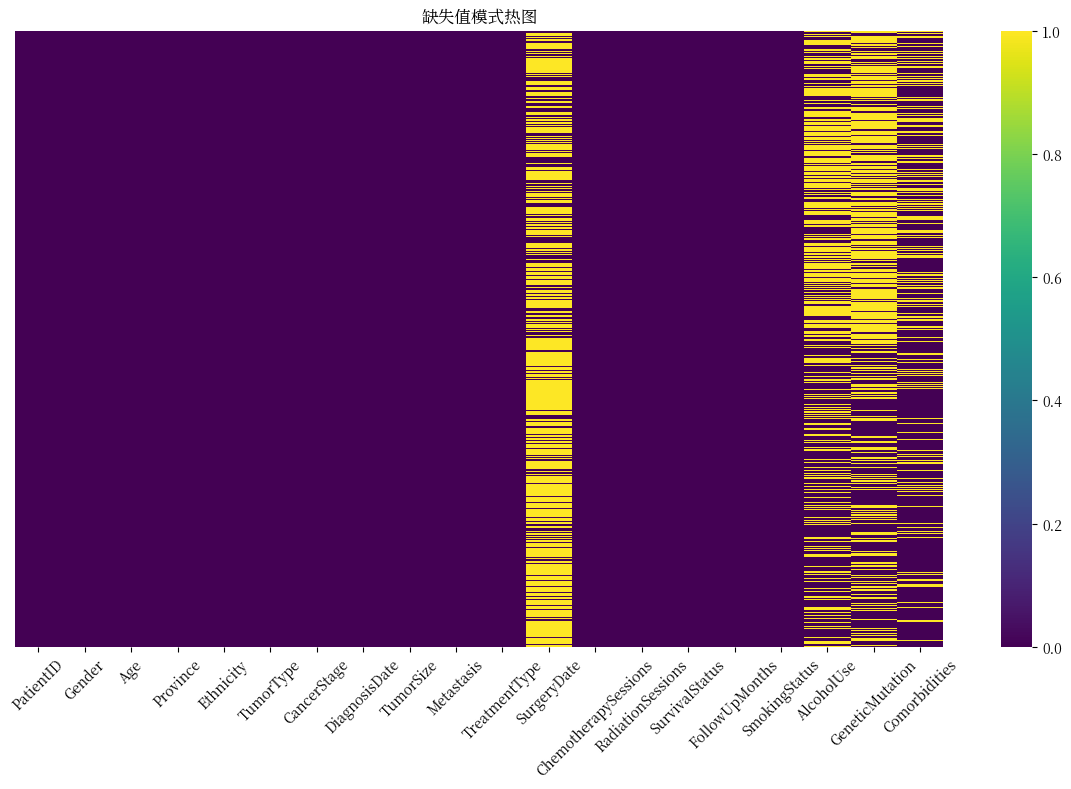

In [5]:
# 缺失值分析
def analyze_missing_values(df):
    """分析缺失值情况"""
    missing_stats = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
        'Data_Type': df.dtypes
    })
    
    # 添加非标准缺失值（如'N/A', '', 'None'等）
    for col in df.columns:
        if df[col].dtype == 'object':
            non_standard_missing = df[col].isin(['N/A', '', 'None', 'null', 'NULL']).sum()
            missing_stats.loc[missing_stats['Column'] == col, 'Non_Standard_Missing'] = non_standard_missing
            missing_stats.loc[missing_stats['Column'] == col, 'Total_Missing'] = (
                missing_stats.loc[missing_stats['Column'] == col, 'Missing_Count'].values[0] + non_standard_missing
            )
        else:
            missing_stats.loc[missing_stats['Column'] == col, 'Non_Standard_Missing'] = 0
            missing_stats.loc[missing_stats['Column'] == col, 'Total_Missing'] = missing_stats.loc[missing_stats['Column'] == col, 'Missing_Count'].values[0]
    
    missing_stats['Total_Missing_Percentage'] = (missing_stats['Total_Missing'] / len(df)) * 100
    missing_stats = missing_stats.sort_values('Total_Missing_Percentage', ascending=False)
    
    return missing_stats

missing_analysis = analyze_missing_values(df)
print("缺失值分析结果:")
display(missing_analysis)

# 可视化缺失值模式
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('缺失值模式热图')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# 处理非标准缺失值
def clean_missing_values(df):
    """清理非标准缺失值"""
    df_clean = df.copy()
    
    # 将非标准缺失值替换为NaN
    non_standard_missing = ['N/A', '', 'None', 'null', 'NULL', ' ']
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].replace(non_standard_missing, np.nan)
    
    return df_clean

df_clean = clean_missing_values(df)

# 重新分析清理后的缺失值
print("清理后的缺失值统计:")
missing_clean = df_clean.isnull().sum().sort_values(ascending=False)
missing_clean_pct = (missing_clean / len(df_clean)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_clean,
    'Missing_Percentage': missing_clean_pct
})

display(missing_summary[missing_summary['Missing_Count'] > 0])

# 数据质量概览
print(f"\n数据质量概览:")
print(f"总样本数: {len(df_clean)}")
print(f"有缺失值的列数: {(df_clean.isnull().any()).sum()}")
print(f"完全没有缺失值的样本数: {df_clean.dropna().shape[0]}")
print(f"完整度: {(df_clean.dropna().shape[0] / len(df_clean)) * 100:.2f}%")

清理后的缺失值统计:


,Missing_Count,Missing_Percentage
SurgeryDate,13734,68.670
GeneticMutation,10401,52.005
AlcoholUse,9234,46.170
Comorbidities,5114,25.570



数据质量概览:
总样本数: 20000
有缺失值的列数: 4
完全没有缺失值的样本数: 1071
完整度: 5.36%


## 4. 数据预处理和特征工程

In [7]:
# 创建工作副本
df_processed = df_clean.copy()

# 1. 处理日期字段
print("处理日期字段...")

def parse_date_safe(date_str):
    """安全解析日期"""
    if pd.isna(date_str):
        return None
    try:
        return parser.parse(str(date_str))
    except:
        return None

# 转换日期字段
df_processed['DiagnosisDate'] = df_processed['DiagnosisDate'].apply(parse_date_safe)
df_processed['SurgeryDate'] = df_processed['SurgeryDate'].apply(parse_date_safe)

# 2. 创建生存分析必需的变量
print("创建生存分析变量...")

# 生存状态转换为事件指示器（1=死亡，0=存活/右删失）
df_processed['Event'] = (df_processed['SurvivalStatus'] == 'Deceased').astype(int)

# 生存时间（使用FollowUpMonths作为观察时间）
df_processed['Duration'] = df_processed['FollowUpMonths']

# 检查生存时间的有效性
print(f"生存时间统计:")
print(f"最小值: {df_processed['Duration'].min()}")
print(f"最大值: {df_processed['Duration'].max()}")
print(f"平均值: {df_processed['Duration'].mean():.2f}")
print(f"事件发生率: {df_processed['Event'].mean():.2%}")

# 3. 处理分类变量
print("\n处理分类变量...")

# 定义分类变量
categorical_features = ['Gender', 'Province', 'Ethnicity', 'TumorType', 'CancerStage', 
                       'Metastasis', 'TreatmentType', 'SmokingStatus', 'AlcoholUse']

# 处理缺失值和编码
for col in categorical_features:
    if col in df_processed.columns:
        # 用众数填充缺失值
        mode_value = df_processed[col].mode().iloc[0] if not df_processed[col].mode().empty else 'Unknown'
        df_processed[col] = df_processed[col].fillna(mode_value)
        print(f"{col}: 填充缺失值 ({df_clean[col].isnull().sum()} 个) -> '{mode_value}'")

处理日期字段...
创建生存分析变量...
生存时间统计:
最小值: 1
最大值: 60
平均值: 30.49
事件发生率: 36.20%

处理分类变量...
Gender: 填充缺失值 (0 个) -> 'Male'
Province: 填充缺失值 (0 个) -> 'Guangdong'
Ethnicity: 填充缺失值 (0 个) -> 'Han'
TumorType: 填充缺失值 (0 个) -> 'Lung'
CancerStage: 填充缺失值 (0 个) -> 'II'
Metastasis: 填充缺失值 (0 个) -> 'No'
TreatmentType: 填充缺失值 (0 个) -> 'Chemotherapy'
SmokingStatus: 填充缺失值 (0 个) -> 'Never'
AlcoholUse: 填充缺失值 (9234 个) -> 'Occasional'
创建生存分析变量...
生存时间统计:
最小值: 1
最大值: 60
平均值: 30.49
事件发生率: 36.20%

处理分类变量...
Gender: 填充缺失值 (0 个) -> 'Male'
Province: 填充缺失值 (0 个) -> 'Guangdong'
Ethnicity: 填充缺失值 (0 个) -> 'Han'
TumorType: 填充缺失值 (0 个) -> 'Lung'
CancerStage: 填充缺失值 (0 个) -> 'II'
Metastasis: 填充缺失值 (0 个) -> 'No'
TreatmentType: 填充缺失值 (0 个) -> 'Chemotherapy'
SmokingStatus: 填充缺失值 (0 个) -> 'Never'
AlcoholUse: 填充缺失值 (9234 个) -> 'Occasional'


In [8]:
# 4. 处理数值变量
print("\n处理数值变量...")

# 数值变量列表
numerical_features = ['Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions']

# 处理数值变量的缺失值
for col in numerical_features:
    if col in df_processed.columns:
        missing_count = df_processed[col].isnull().sum()
        if missing_count > 0:
            # 用中位数填充缺失值
            median_value = df_processed[col].median()
            df_processed[col] = df_processed[col].fillna(median_value)
            print(f"{col}: 填充 {missing_count} 个缺失值 -> 中位数 {median_value}")

# 5. 特征工程
print("\n特征工程...")

# 年龄分组
df_processed['AgeGroup'] = pd.cut(df_processed['Age'], 
                                 bins=[0, 30, 50, 70, 100], 
                                 labels=['Young', 'Middle', 'Senior', 'Elderly'])

# 肿瘤大小分组
df_processed['TumorSizeGroup'] = pd.cut(df_processed['TumorSize'],
                                       bins=[0, 5, 10, 15, float('inf')],
                                       labels=['Small', 'Medium', 'Large', 'VeryLarge'])

# 治疗强度指标
df_processed['TreatmentIntensity'] = (df_processed['ChemotherapySessions'] + 
                                     df_processed['RadiationSessions'])

# 是否接受手术
df_processed['HasSurgery'] = (~df_processed['SurgeryDate'].isna()).astype(int)

# 是否有并发症
df_processed['HasComorbidities'] = (~df_processed['Comorbidities'].isna()).astype(int)

# 是否有基因突变
df_processed['HasGeneticMutation'] = (~df_processed['GeneticMutation'].isna()).astype(int)

print("特征工程完成！")
print(f"新增特征: AgeGroup, TumorSizeGroup, TreatmentIntensity, HasSurgery, HasComorbidities, HasGeneticMutation")


处理数值变量...

特征工程...
特征工程完成！
新增特征: AgeGroup, TumorSizeGroup, TreatmentIntensity, HasSurgery, HasComorbidities, HasGeneticMutation


In [9]:
# 6. 编码分类变量
print("编码分类变量...")

# 为生存分析准备编码后的数据
df_encoded = df_processed.copy()

# 使用Label Encoding处理有序分类变量
ordinal_features = {
    'CancerStage': ['I', 'II', 'III', 'IV'],
    'AgeGroup': ['Young', 'Middle', 'Senior', 'Elderly'],
    'TumorSizeGroup': ['Small', 'Medium', 'Large', 'VeryLarge']
}

label_encoders = {}
for feature, order in ordinal_features.items():
    if feature in df_encoded.columns:
        le = LabelEncoder()
        # 确保编码顺序
        df_encoded[feature] = df_encoded[feature].astype('category')
        if feature == 'CancerStage':
            df_encoded[feature] = df_encoded[feature].cat.reorder_categories(order, ordered=True)
        elif feature in ['AgeGroup', 'TumorSizeGroup']:
            df_encoded[feature] = df_encoded[feature].cat.reorder_categories(order, ordered=True)
        
        df_encoded[feature + '_encoded'] = le.fit_transform(df_encoded[feature])
        label_encoders[feature] = le
        print(f"{feature} 编码映射: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 使用One-Hot Encoding处理无序分类变量
nominal_features = ['Gender', 'Province', 'Ethnicity', 'TumorType', 'Metastasis', 
                   'TreatmentType', 'SmokingStatus', 'AlcoholUse']

for feature in nominal_features:
    if feature in df_encoded.columns:
        # 获取哑变量
        dummies = pd.get_dummies(df_encoded[feature], prefix=feature, drop_first=True)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        print(f"{feature}: 创建 {dummies.shape[1]} 个哑变量")

print(f"\n编码后数据形状: {df_encoded.shape}")

编码分类变量...
CancerStage 编码映射: {'I': np.int64(0), 'II': np.int64(1), 'III': np.int64(2), 'IV': np.int64(3)}
AgeGroup 编码映射: {'Elderly': np.int64(0), 'Middle': np.int64(1), 'Senior': np.int64(2), 'Young': np.int64(3), nan: np.int64(4)}
TumorSizeGroup 编码映射: {'Large': np.int64(0), 'Medium': np.int64(1), 'Small': np.int64(2), nan: np.int64(3)}
Gender: 创建 3 个哑变量
Province: 创建 12 个哑变量
Ethnicity: 创建 5 个哑变量
TumorType: 创建 5 个哑变量
Metastasis: 创建 1 个哑变量
TreatmentType: 创建 5 个哑变量
SmokingStatus: 创建 2 个哑变量
AlcoholUse: 创建 2 个哑变量

编码后数据形状: (20000, 66)


## 5. 探索性数据分析（EDA）

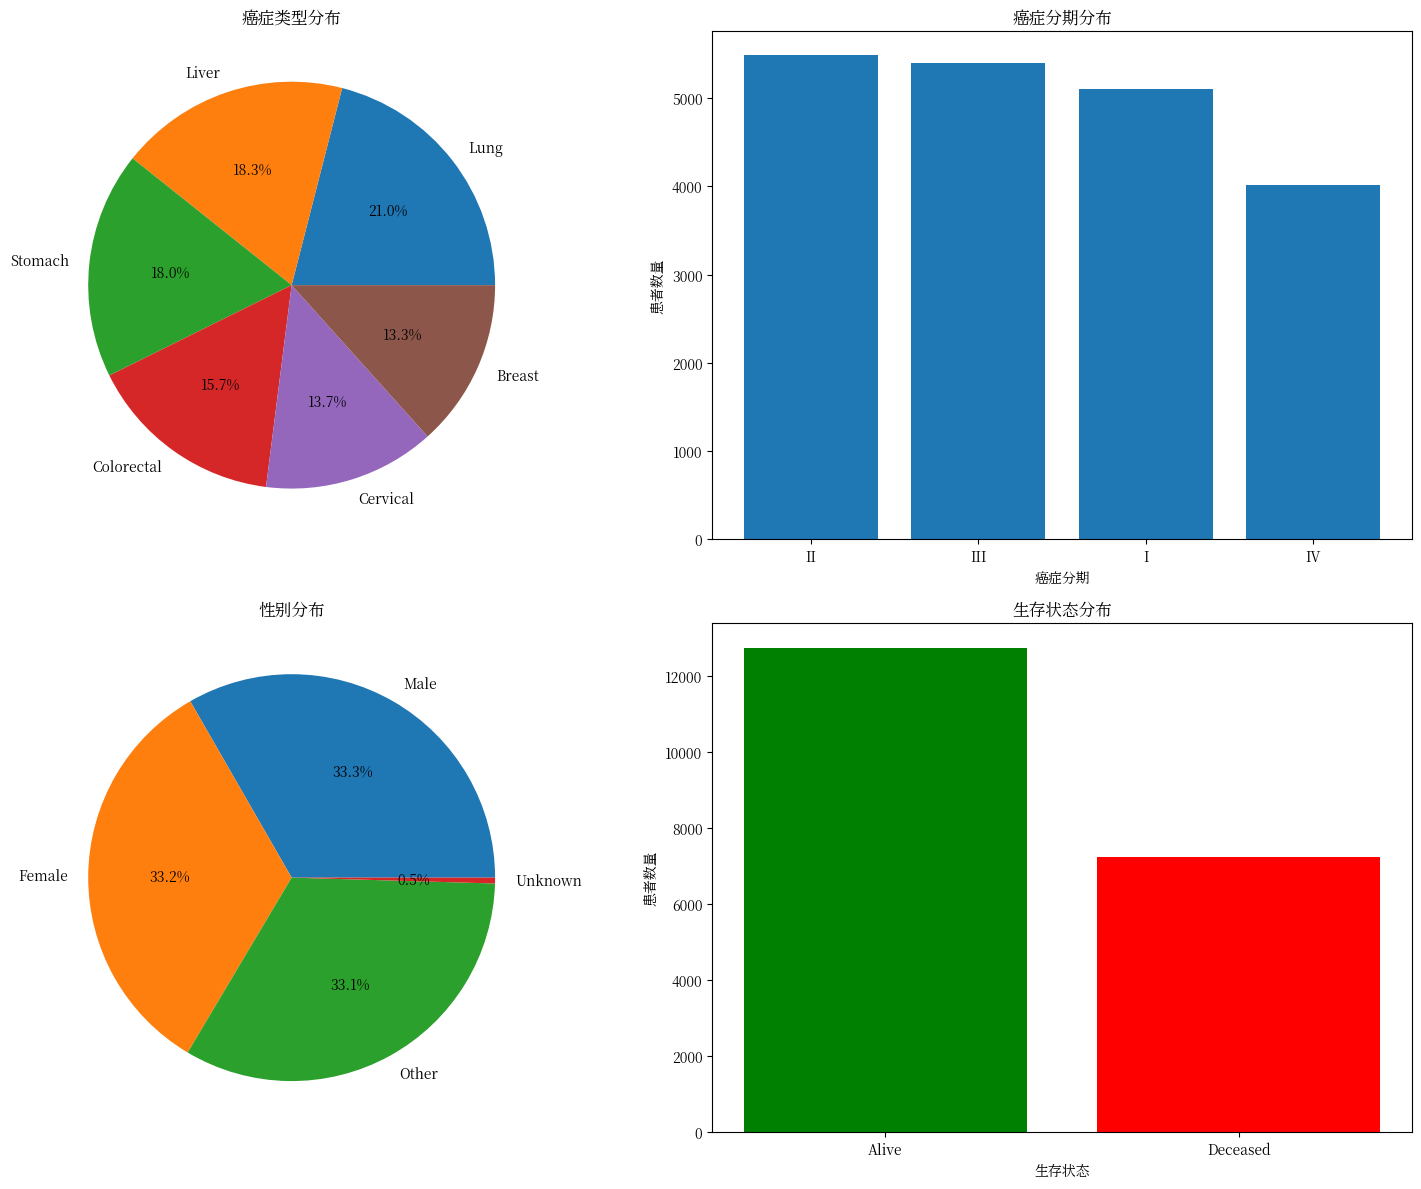

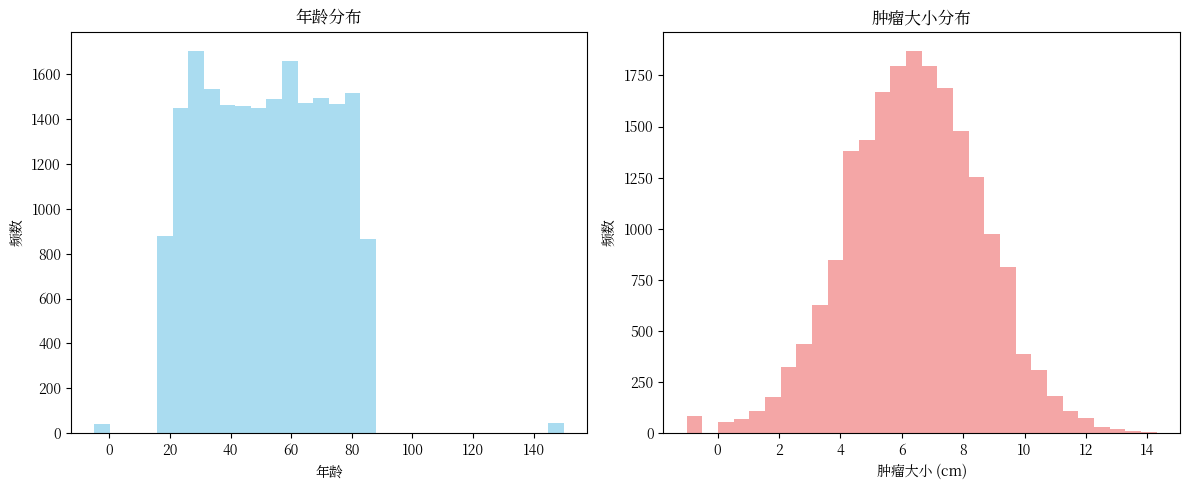

In [10]:
# 1. 癌症类型分布
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 癌症类型分布
tumor_counts = df_processed['TumorType'].value_counts()
axes[0,0].pie(tumor_counts.values, labels=tumor_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('癌症类型分布')

# 癌症分期分布
stage_counts = df_processed['CancerStage'].value_counts()
axes[0,1].bar(stage_counts.index, stage_counts.values)
axes[0,1].set_title('癌症分期分布')
axes[0,1].set_xlabel('癌症分期')
axes[0,1].set_ylabel('患者数量')

# 性别分布
gender_counts = df_processed['Gender'].value_counts()
axes[1,0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
axes[1,0].set_title('性别分布')

# 生存状态分布
survival_counts = df_processed['SurvivalStatus'].value_counts()
axes[1,1].bar(survival_counts.index, survival_counts.values, color=['green', 'red'])
axes[1,1].set_title('生存状态分布')
axes[1,1].set_xlabel('生存状态')
axes[1,1].set_ylabel('患者数量')

plt.tight_layout()
plt.show()

# 2. 年龄和肿瘤大小分布
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 年龄分布
axes[0].hist(df_processed['Age'], bins=30, alpha=0.7, color='skyblue')
axes[0].set_title('年龄分布')
axes[0].set_xlabel('年龄')
axes[0].set_ylabel('频数')

# 肿瘤大小分布
axes[1].hist(df_processed['TumorSize'].dropna(), bins=30, alpha=0.7, color='lightcoral')
axes[1].set_title('肿瘤大小分布')
axes[1].set_xlabel('肿瘤大小 (cm)')
axes[1].set_ylabel('频数')

plt.tight_layout()
plt.show()

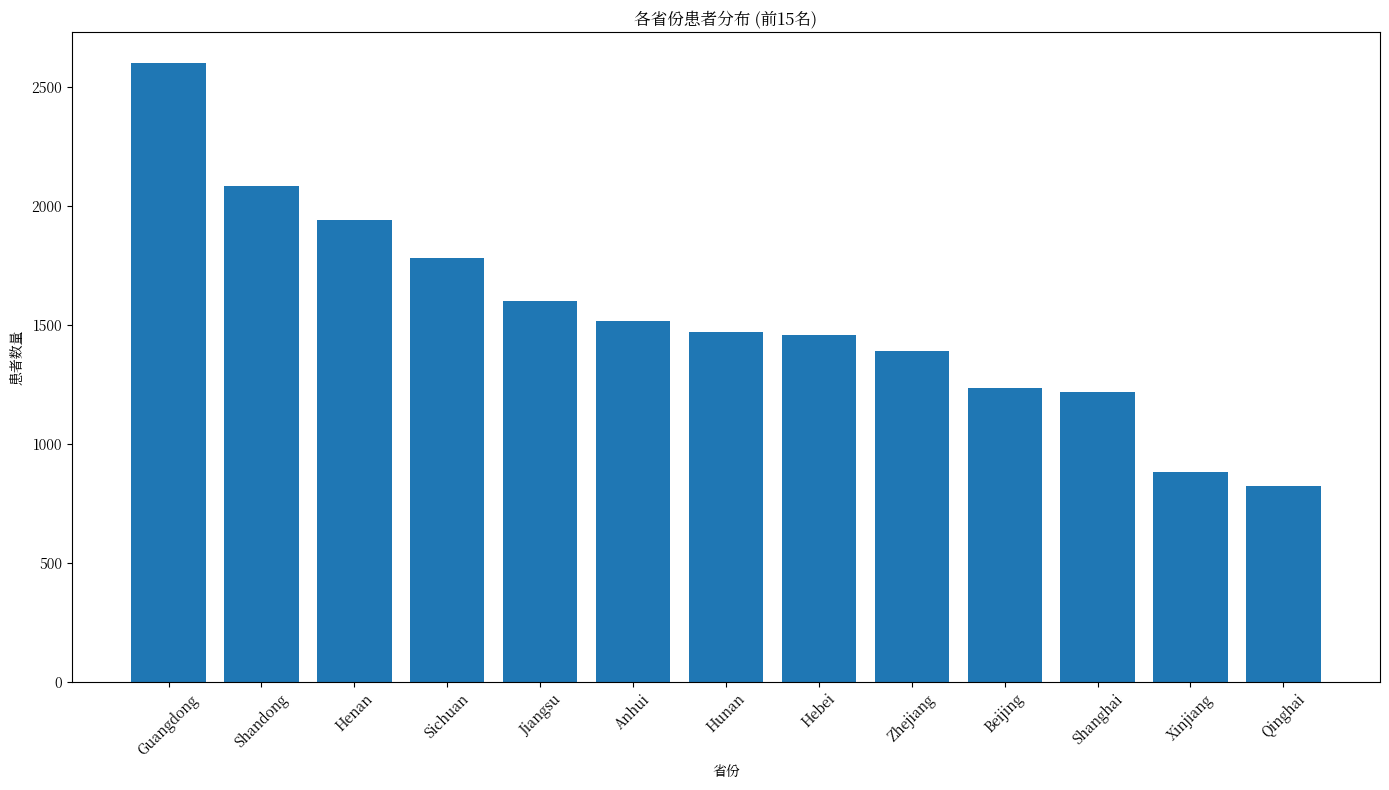

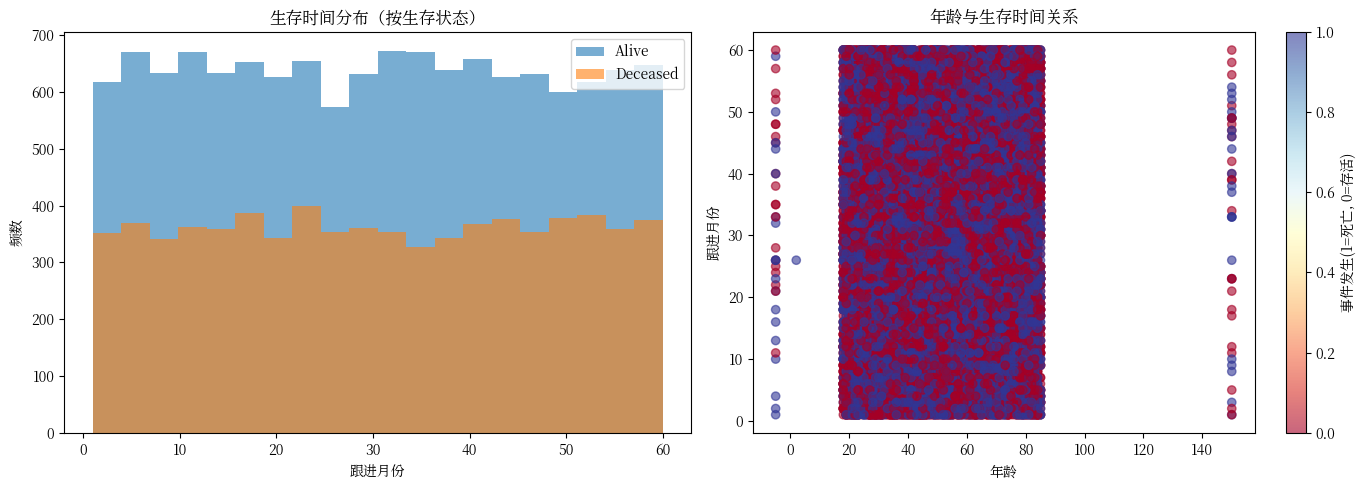

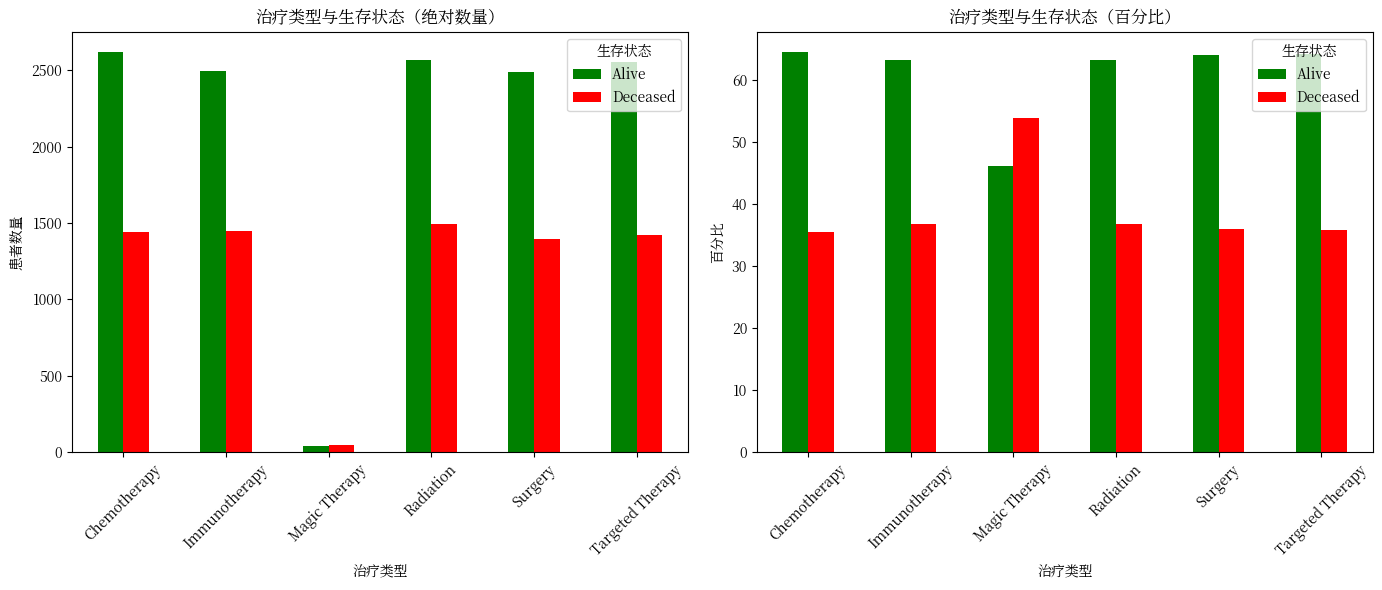

In [11]:
# 3. 地区分布分析
plt.figure(figsize=(14, 8))
province_counts = df_processed['Province'].value_counts().head(15)  # 显示前15个省份
plt.bar(range(len(province_counts)), province_counts.values)
plt.title('各省份患者分布 (前15名)')
plt.xlabel('省份')
plt.ylabel('患者数量')
plt.xticks(range(len(province_counts)), province_counts.index, rotation=45)
plt.tight_layout()
plt.show()

# 4. 生存时间与生存状态关系
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 生存时间分布（按生存状态分组）
for status in df_processed['SurvivalStatus'].unique():
    subset = df_processed[df_processed['SurvivalStatus'] == status]['Duration']
    axes[0].hist(subset, alpha=0.6, label=status, bins=20)
axes[0].set_title('生存时间分布（按生存状态）')
axes[0].set_xlabel('跟进月份')
axes[0].set_ylabel('频数')
axes[0].legend()

# 年龄与生存时间关系
scatter = axes[1].scatter(df_processed['Age'], df_processed['Duration'], 
                         c=df_processed['Event'], alpha=0.6, cmap='RdYlBu')
axes[1].set_title('年龄与生存时间关系')
axes[1].set_xlabel('年龄')
axes[1].set_ylabel('跟进月份')
plt.colorbar(scatter, ax=axes[1], label='事件发生(1=死亡, 0=存活)')

plt.tight_layout()
plt.show()

# 5. 治疗类型与生存状态关系
treatment_survival = pd.crosstab(df_processed['TreatmentType'], df_processed['SurvivalStatus'])
treatment_survival_pct = pd.crosstab(df_processed['TreatmentType'], df_processed['SurvivalStatus'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 绝对数量
treatment_survival.plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('治疗类型与生存状态（绝对数量）')
axes[0].set_xlabel('治疗类型')
axes[0].set_ylabel('患者数量')
axes[0].legend(title='生存状态')
axes[0].tick_params(axis='x', rotation=45)

# 百分比
treatment_survival_pct.plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('治疗类型与生存状态（百分比）')
axes[1].set_xlabel('治疗类型')
axes[1].set_ylabel('百分比')
axes[1].legend(title='生存状态')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. 生存分析数据准备

In [12]:
# 1. 创建最终的建模数据集
print("准备建模数据集...")

# 选择用于建模的特征
feature_columns = [
    # 基础特征
    'Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions',
    'TreatmentIntensity', 'HasSurgery', 'HasComorbidities', 'HasGeneticMutation',
    
    # 编码后的有序特征
    'CancerStage_encoded', 'AgeGroup_encoded', 'TumorSizeGroup_encoded'
]

# 添加所有的哑变量
dummy_columns = [col for col in df_encoded.columns if any(prefix in col for prefix in 
                ['Gender_', 'Province_', 'Ethnicity_', 'TumorType_', 'Metastasis_', 
                 'TreatmentType_', 'SmokingStatus_', 'AlcoholUse_'])]

feature_columns.extend(dummy_columns)

# 生存分析目标变量
target_columns = ['Duration', 'Event']

# 检查特征是否存在
available_features = [col for col in feature_columns if col in df_encoded.columns]
missing_features = [col for col in feature_columns if col not in df_encoded.columns]

print(f"可用特征数量: {len(available_features)}")
print(f"缺失特征: {missing_features}")

# 创建建模数据集
modeling_data = df_encoded[available_features + target_columns + ['PatientID']].copy()

# 移除任何仍有缺失值的行
print(f"处理前数据形状: {modeling_data.shape}")
modeling_data = modeling_data.dropna()
print(f"处理后数据形状: {modeling_data.shape}")

# 2. 数据质量检查
print(f"\n数据质量检查:")
print(f"生存时间范围: {modeling_data['Duration'].min()} - {modeling_data['Duration'].max()}")
print(f"事件发生率: {modeling_data['Event'].mean():.2%}")
print(f"平均随访时间: {modeling_data['Duration'].mean():.1f} 月")

# 3. 特征统计
X = modeling_data[available_features]
y_duration = modeling_data['Duration']
y_event = modeling_data['Event']

print(f"\n特征矩阵形状: {X.shape}")
print(f"特征数量: {len(available_features)}")
print(f"样本数量: {len(modeling_data)}")

# 显示特征列表
print(f"\n建模特征列表:")
for i, feature in enumerate(available_features, 1):
    print(f"{i:2d}. {feature}")
    if i % 5 == 0:  # 每5个特征换行
        print()

准备建模数据集...
可用特征数量: 46
缺失特征: []
处理前数据形状: (20000, 49)
处理后数据形状: (20000, 49)

数据质量检查:
生存时间范围: 1 - 60
事件发生率: 36.20%
平均随访时间: 30.5 月

特征矩阵形状: (20000, 46)
特征数量: 46
样本数量: 20000

建模特征列表:
 1. Age
 2. TumorSize
 3. ChemotherapySessions
 4. RadiationSessions
 5. TreatmentIntensity

 6. HasSurgery
 7. HasComorbidities
 8. HasGeneticMutation
 9. CancerStage_encoded
10. AgeGroup_encoded

11. TumorSizeGroup_encoded
12. Gender_Male
13. Gender_Other
14. Gender_Unknown
15. Province_Beijing

16. Province_Guangdong
17. Province_Hebei
18. Province_Henan
19. Province_Hunan
20. Province_Jiangsu

21. Province_Qinghai
22. Province_Shandong
23. Province_Shanghai
24. Province_Sichuan
25. Province_Xinjiang

26. Province_Zhejiang
27. Ethnicity_Hui
28. Ethnicity_Other
29. Ethnicity_Tibetan
30. Ethnicity_Uyghur

31. Ethnicity_Zhuang
32. TumorType_Cervical
33. TumorType_Colorectal
34. TumorType_Liver
35. TumorType_Lung

36. TumorType_Stomach
37. Metastasis_Yes
38. TreatmentType_Immunotherapy
39. TreatmentType_Magic The

In [13]:
# 4. 数据标准化（为深度学习模型准备）
print("数据标准化...")

# 分离数值特征和分类特征
numerical_cols = ['Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions', 'TreatmentIntensity']
categorical_cols = [col for col in available_features if col not in numerical_cols]

print(f"数值特征: {len(numerical_cols)} 个")
print(f"分类特征: {len(categorical_cols)} 个")

# 标准化数值特征
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X[numerical_cols])

print("数值特征标准化完成")

# 5. 数据分割
print("\n数据集分割...")

# 分层抽样，确保训练集和测试集的事件率相似
X_train, X_test, y_train_duration, y_test_duration, y_train_event, y_test_event = train_test_split(
    X_scaled, y_duration, y_event, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_event
)

print(f"训练集大小: {X_train.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")
print(f"训练集事件率: {y_train_event.mean():.2%}")
print(f"测试集事件率: {y_test_event.mean():.2%}")

# 6. 保存预处理器和编码器
print("\n保存预处理器...")

preprocessors = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': available_features,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols
}

# 保存到文件
with open(processed_data_dir / 'preprocessors.pkl', 'wb') as f:
    pickle.dump(preprocessors, f)

print("预处理器保存完成")

数据标准化...
数值特征: 5 个
分类特征: 41 个
数值特征标准化完成

数据集分割...
训练集大小: 16000
测试集大小: 4000
训练集事件率: 36.20%
测试集事件率: 36.20%

保存预处理器...
预处理器保存完成


## 7. 保存处理后的数据

In [14]:
# 1. 保存原始清理后的数据
df_processed.to_csv(processed_data_dir / 'cleaned_data.csv', index=False)
print("清理后的原始数据已保存: cleaned_data.csv")

# 2. 保存编码后的完整数据
df_encoded.to_csv(processed_data_dir / 'encoded_data.csv', index=False)
print("编码后的完整数据已保存: encoded_data.csv")

# 3. 保存建模数据集
modeling_data.to_csv(processed_data_dir / 'modeling_data.csv', index=False)
print("建模数据集已保存: modeling_data.csv")

# 4. 保存分割后的训练和测试数据
train_data = pd.concat([
    X_train, 
    pd.DataFrame({'Duration': y_train_duration, 'Event': y_train_event}, index=X_train.index)
], axis=1)

test_data = pd.concat([
    X_test, 
    pd.DataFrame({'Duration': y_test_duration, 'Event': y_test_event}, index=X_test.index)
], axis=1)

train_data.to_csv(processed_data_dir / 'train_data.csv', index=False)
test_data.to_csv(processed_data_dir / 'test_data.csv', index=False)

print("训练数据已保存: train_data.csv")
print("测试数据已保存: test_data.csv")

# 5. 保存数据摘要报告
summary_report = {
    'original_shape': df.shape,
    'processed_shape': modeling_data.shape,
    'feature_count': len(available_features),
    'sample_count': len(modeling_data),
    'event_rate': modeling_data['Event'].mean(),
    'mean_followup': modeling_data['Duration'].mean(),
    'train_size': len(train_data),
    'test_size': len(test_data),
    'features': available_features
}

with open(processed_data_dir / 'data_summary.txt', 'w', encoding='utf-8') as f:
    f.write("数据预处理摘要报告\n")
    f.write("=" * 30 + "\n\n")
    f.write(f"原始数据形状: {summary_report['original_shape']}\n")
    f.write(f"处理后数据形状: {summary_report['processed_shape']}\n")
    f.write(f"特征数量: {summary_report['feature_count']}\n")
    f.write(f"样本数量: {summary_report['sample_count']}\n")
    f.write(f"事件发生率: {summary_report['event_rate']:.2%}\n")
    f.write(f"平均随访时间: {summary_report['mean_followup']:.1f} 月\n")
    f.write(f"训练集大小: {summary_report['train_size']}\n")
    f.write(f"测试集大小: {summary_report['test_size']}\n\n")
    f.write("特征列表:\n")
    for i, feature in enumerate(summary_report['features'], 1):
        f.write(f"{i:2d}. {feature}\n")

print("数据摘要报告已保存: data_summary.txt")

print(f"\n数据预处理完成！")
print(f"所有文件已保存到: {processed_data_dir}")
print(f"共生成 {len(list(processed_data_dir.glob('*')))} 个文件")

清理后的原始数据已保存: cleaned_data.csv
编码后的完整数据已保存: encoded_data.csv
建模数据集已保存: modeling_data.csv
训练数据已保存: train_data.csv
测试数据已保存: test_data.csv
数据摘要报告已保存: data_summary.txt

数据预处理完成！
所有文件已保存到: ../data/processed
共生成 8 个文件
建模数据集已保存: modeling_data.csv
训练数据已保存: train_data.csv
测试数据已保存: test_data.csv
数据摘要报告已保存: data_summary.txt

数据预处理完成！
所有文件已保存到: ../data/processed
共生成 8 个文件
